<a href="https://colab.research.google.com/github/kendallbrogle/indaba-pracs-2024/blob/main/Responsible_AI_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Responsible AI**
**Part 1: ProPublica's Analysis of the COMPAS Tool**

**Part 2: Detecting and Mitigating Biases using Fairlearn**


<img src="https://drive.google.com/uc?export=view&id=1W3nZF2AUsSbIKo_ekazO_rYDcPQSRzi8" width="50%" />

<a href="https://colab.research.google.com/drive/1tWWxMkonHYbZi_J7wDTr2Zl2CCHKyZPD" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** Umang Bhatt and Kendall Brogle

**Introduction:**

This notebook provides a hands-on exploration of responsible AI through two parts: analyzing ProPublica's analysis of the COMPAS risk assessment tool and examining biases using the Fairlearn toolkit. The first part focuses ion ProPublica's investigation of COMPAS, specifically, on how its recidivism scores vary by race and sex. This involves data import, preprocessing, exploratory analysis, and logistic regression modeling to reproduce and interpret ProPublica's findings. The second part transitions to detecting and mitigating biases using Fairlearn, a library designed to assess and improve fairness in machine learning models. By engaging with both theoretical and practical aspects of responsible AI, this notebook aims to enhance understanding of bias in AI systems and the tools available to address

**Topics:**

Content: Responsible AI, Bias Detection and Mitigation, Logistic Regression, Fairness in AI models

Level: Intermediate, Advanced


**Aims/Learning Objectives:**

1) Understand and analyze bias in the COMPAS risk assessment tool.

2) Apply logistic regression to explore racial bias in risk scores.

3) Use the Fairlearn package to detect and mitigate biases in models.

4) Evaluating fairness with metrics like demographic parity difference and ratio.


**Prerequisites:**

Basic understanding of machine learning concepts.

Familiarity with Python and libraries like Pandas, Scikit-learn, and Matplotlib.

Understanding of logistic regression and classification metrics.

Familiarity with concepts of bias and fairness in AI.

**Outline:**

>[Installation and Imports](#scrollTo=6EqhIg1odqg0)

>[Part 1: ProPublica's Analysis of the COMPAS Tool](#scrollTo=G2sewZEq36T0)

>[Part 2:  Detecting and Mitigating Biases using Fairlearn](#scrollTo=253jTpcO60Mf)

>[Conclusion](#scrollTo=fV3YG7QOZD-B)

**Before you start:**

Ensure all required Python packages are installed.

Familiarize yourself with the dataset and variable descriptions.

Review the key concepts of logistic regression and bias in AI.

## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import subprocess
import os

# Function to check for GPU/TPU and setup environment
def check_accelerator():
    try:
        subprocess.check_output('nvidia-smi')
        print("A GPU is connected.")
    except Exception:
        # TPU or CPU
        if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
            print("A TPU is connected.")
            import jax.tools.colab_tpu
            jax.tools.colab_tpu.setup_tpu()
        else:
            print("Only CPU accelerator is connected.")
            # x8 cpu devices - number of (emulated) host devices
            os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

check_accelerator()

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import math

%matplotlib inline

# Import the data
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

# For part 2
# @markdown
!pip install fairlearn folktables
!git clone https://github.com/lurosenb/superquail

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData
from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, ErrorRate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, demographic_parity_difference, demographic_parity_ratio, selection_rate, false_negative_rate, false_positive_rate
from IPython.display import clear_output

Only CPU accelerator is connected.
fatal: destination path 'superquail' already exists and is not an empty directory.


# **Part 1: ProPublica's Analysis of the COMPAS Tool**

In 2016, [ProPublica published an analysis](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) tool. COMPAS is a proprietary tool which generates a so-called risk assessment for defendants in a criminal trial. ProPublica's analysis focused on the "recidivism score," which purports to provide the likelihood of recidivism (i.e. committing a misdemeanor of felony) within two years of assessment.

In this lab, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex.

This section has four stages in which we will:
1. Check the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

# Check Data

Check the first few rows of data from ProPublica's compas-analysis repository on GitHub:

In [ ]:
df_compas = pd.read_csv(url)
print("Shape: ", df_compas.shape)
df_compas.head(5)

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Notes on the Data

Refer to the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). Salient points are highlighted below; see the full description from ProPublica for additional details.

> **Goal:** We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.
>
> **COMPAS tool input (data subjects):** When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of Risk of Recidivism and Risk of Violent Recidivism.
>
> **How COMPAS input was acquired by ProPublica:** Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.
>
> **COMPAS tool output:** Each pretrial defendant received at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear. [...] COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as "Low;" 5 to 7 were labeled “Medium;" and 8 to 10 were labeled “High.”
>
> **Data integration (record linkage):** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19). We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.
>
> **What is recidivism?** Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. [...] For most of our analysis, we defined recidivism as a new arrest within two years.

# Inspect Data

For convenience, here is a table of variable definitions:

| Variable    | Description |
| ----------- | ----------- |
| age       |  Age of the defendant   |
| age_cat   |  Age category. It can be < 25, 25-45, >45    |
| sex   |  Sex of the defendant. It is either "Male" or "Female"       |
| race   |  Race of the defendant. It can be "African-American", "Caucasian", "Hispanic", "Asian", or "Other"      |
| c_charge_degree   |   Charge. Either "M" for misdemeanor, "F" for felony, or "O" (not causing jail time)    |
| priors_count   |   Count of prior crimes committed by the defendant      |
| days_b_screening_arrest   |  Days between the arrest and COMPAS screening       |
| decile_score   |  The COMPAS score estimated by the system. It is between 0-10       |
| score_text   |  Decile score. It can be "Low" (1-4), "Medium" (5-7), or "High" (8-10)       |
| is_recid   |  Indicates if the defendant recidivated. It can be 0, 1, or -1      |
| two_year_recid   |  Indicates if the defendant recidivated within two years of COMPAS assessment      |
| c_jail_in   |   Date the defendant was in jail      |
| c_jail_out  |   Date when the defendant was released from jail     |

\
# **TODO 1** Plot the distribution of age, race, and sex in the imported data (```df_compas```):

In [ ]:
#Your work here:


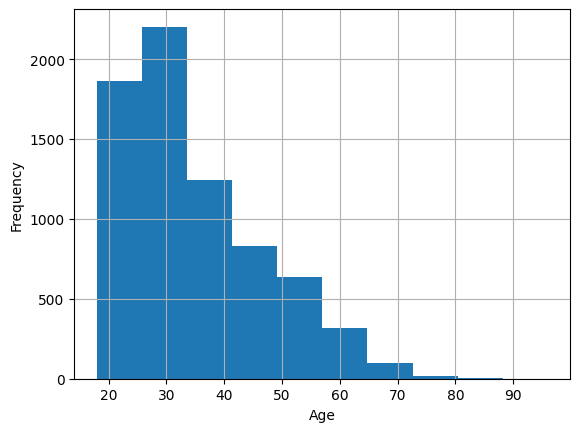

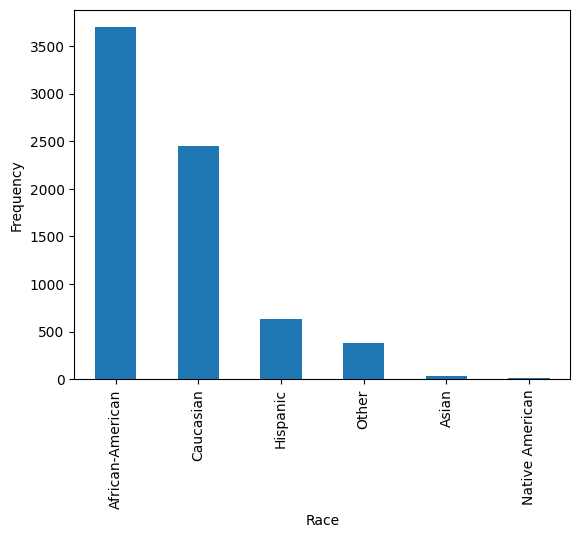

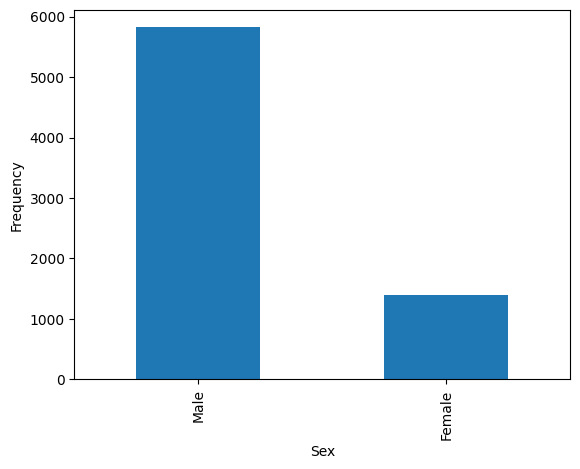

In [ ]:

#@title Answer
df_compas["age"].hist()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

df_compas["race"].value_counts().plot(kind = "bar")
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.show()

df_compas["sex"].value_counts().plot(kind = "bar")
plt.xlabel("Sex")
plt.ylabel("Frequency")
plt.show()

# Preprocess Data

ProPublica implemented a few pre-processing steps. First, they generated a subset of the data with a few variables of interest. Here, we select even fewer variables, keeping only those that we will use in this notebook.

In [ ]:
cols_to_keep = ["id", "age", "c_charge_degree", "race", "age_cat", "score_text",
                "sex", "priors_count", "days_b_screening_arrest",
                "decile_score", "is_recid", "two_year_recid"]

df_selected = df_compas[cols_to_keep].copy()

print("Shape: ", df_selected.shape)
df_selected.head()

Shape:  (7214, 12)


,id,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
3,5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0
4,6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0


Take a moment to get a feel for the variables and structure of the data. ProPublica filtered the above data by removing rows where:

1. The COMPAS score is missing.
1. The charge date of the defendant's COMPAS-scored crime was not within 30 days from the date of arrest. ProPublica assumed that the offense may not be correct in these cases.
2. The recividist flag is "-1". In such cases, ProPublica could not find a COMPAS record at all.
3. The charge is "O". These are ordinary traffic offenses and do not result in jail time.

We implement these conditions here:

In [ ]:
df_analysis = df_selected[
    (df_selected.score_text != "N/A") &
    (df_selected.days_b_screening_arrest <= 30) &
    (df_selected.days_b_screening_arrest >= -30) &
    (df_selected.is_recid != -1) &
    (df_selected.c_charge_degree != "O")
    ].copy()

Note that ProPublica only included people who had recidivated within two years or had at least two years outside a correctional facility. This pre-processing step is "baked in" to the data that we imported from GitHub in this notebook.

# **TODO 2** Check the dimensions (i.e. the number of variables and observations) of the imported (```df_compas```) and preprocessed (```df_analysis```) data:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
print("Imported data", df_compas.shape)
print("Data after selecting variables", df_selected.shape)
print("Data after filtering observations", df_analysis.shape)

Imported data (7214, 53)
Data after selecting variables (7214, 12)
Data after filtering observations (6172, 12)


Take the additional step of making sure that the decile score (discussed below) is numeric:


In [ ]:
df_analysis["decile_score"] = pd.to_numeric(df_analysis["decile_score"])

# Inspect Data Again

# **TODO 3** Re-inspect salient variables in the data after the preprocessing steps. Plot the distribution of age, race, and sex in the preprocessed data (```df_analysis```) and compare these distributions to the imported data (```df_compas```):

In [ ]:
#Your work here:

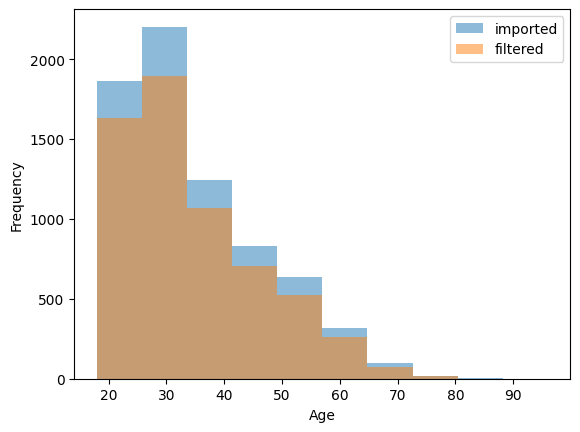

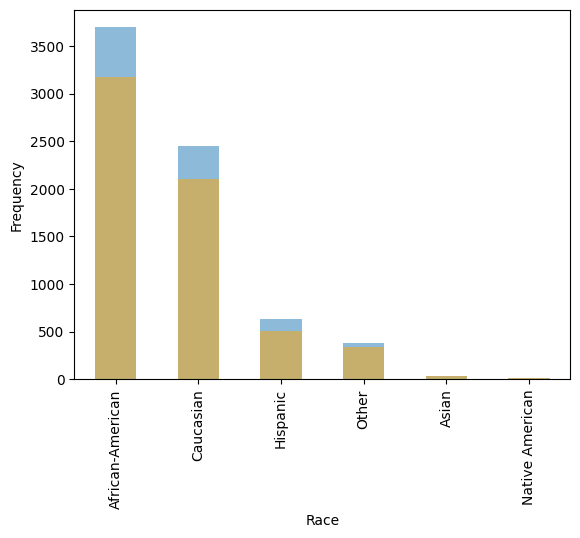

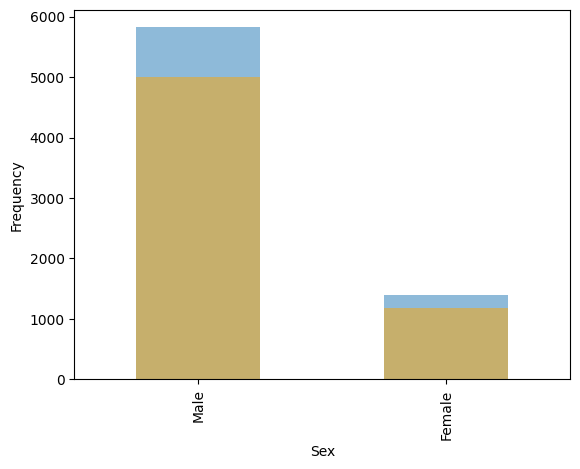

In [ ]:
#@title Answer
plt.hist(df_compas["age"], alpha = 0.5, label = "imported")
plt.hist(df_analysis["age"], alpha = 0.5, label= "filtered")
plt.legend(loc = "upper right")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

df_compas["race"].value_counts().plot(kind = "bar", alpha=0.5)
df_analysis["race"].value_counts().plot(kind = "bar", alpha=0.5, color='orange')
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.show()

df_compas["sex"].value_counts().plot(kind = "bar", alpha=0.5)
df_analysis["sex"].value_counts().plot(kind = "bar", color='orange', alpha=0.5)
plt.xlabel("Sex")
plt.ylabel("Frequency")
plt.show()

# **TODO 4** Observe that we are iterating through the data analysis: import, inspect & profile, preprocess, and profile again. Generate a crosstab summarizing the number of observations by race and sex:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
df_analysis.pivot_table(values = ["id"], columns = ["race"],
                        index = "sex", aggfunc = lambda x: len(x))

id                                               
race   African-American Asian Caucasian Hispanic Native American Other
sex                                                                   
Female              549     2       482       82               2    58
Male               2626    29      1621      427               9   285

# Exploratory Analysis

Let's turn our focus to the primary variable of interest: the COMPAS recidivism score. In this exploratory analysis, we are interested in the variable named "decile_score".

The ProPublica analysis notes: "Judges are often presented with two sets of scores from the COMPAS system: one that classifies people into high, medium or low risk, and a corresponding decile score."

Plot the distribution of decile score for males and for females. To what extent do these distributions differ?

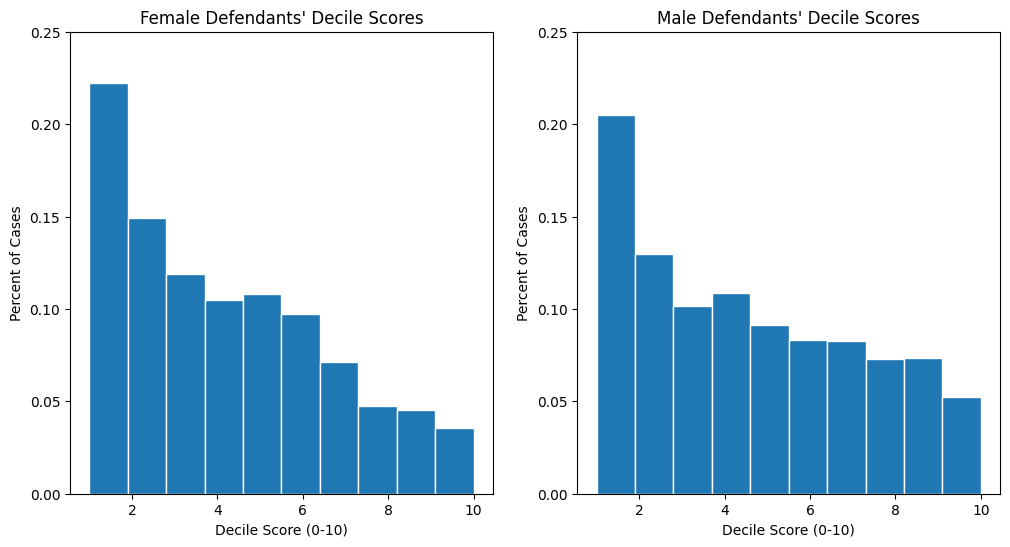

In [ ]:
# plot score decile by sex
df_female = df_analysis[(df_analysis.sex == "Female")].copy()
df_male   = df_analysis[(df_analysis.sex == "Male")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_female["decile_score"], ec = "white",
         weights = np.ones(len(df_female["decile_score"])) /
         len(df_female["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Female Defendants' Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_male["decile_score"], ec = "white",
         weights = np.ones(len(df_male["decile_score"])) /
         len(df_male["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Male Defendants' Decile Scores")
plt.ylim([0, 0.25])

plt.show()

# **TODO 5** What about race? Repeat the above plots for Black defendants and White defendants:

In [ ]:
#Your work here:

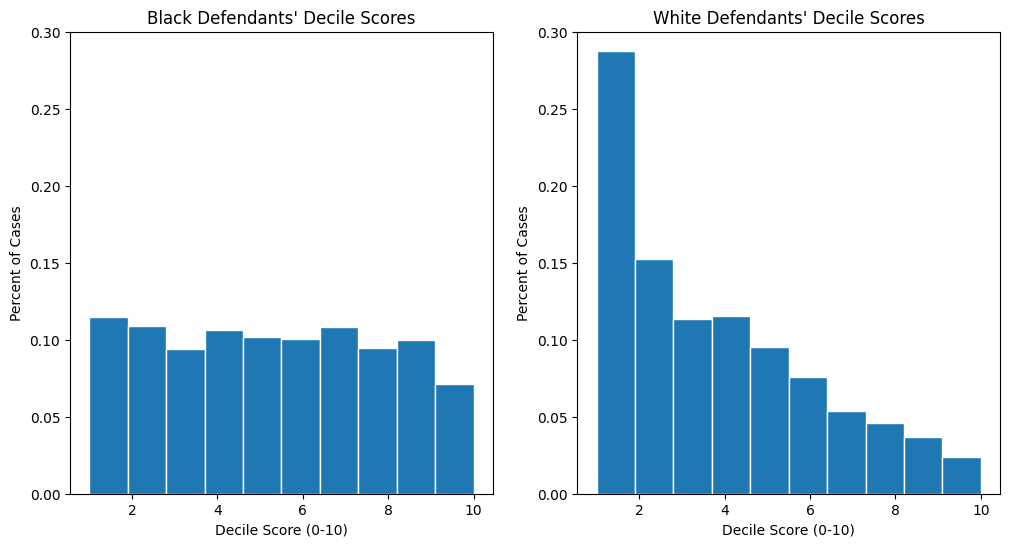

In [ ]:
#@title Answer

# plot score decile by race
df_black = df_analysis[(df_analysis.race == "African-American")]
df_white = df_analysis[(df_analysis.race == "Caucasian")]

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_black["decile_score"], ec = "white",
         weights = np.ones(len(df_black["decile_score"])) /
         len(df_black["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Black Defendants' Decile Scores")
plt.ylim([0, 0.30])

fig.add_subplot(122)
plt.hist(df_white["decile_score"], ec = "white",
         weights = np.ones(len(df_white["decile_score"])) /
         len(df_white["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("White Defendants' Decile Scores")
plt.ylim([0, 0.30])

plt.show()

# **TODO 6** Summarize the difference between the distribution of decile scores for Black defendants and White defendants (three sentences maximum):

Your work here:

# **TODO 7** Plot the distribution of COMPAS-assigned "risk labels" (the variable is named "score_text") for Black defendants and White defendants:

In [ ]:
#Your work here:

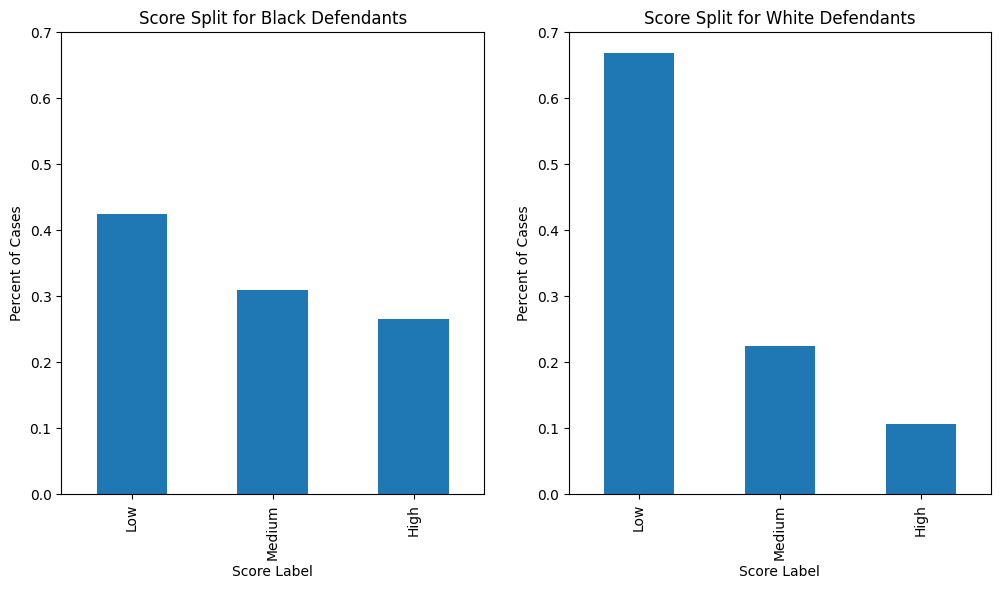

In [ ]:
#@title Answer

# compute risk group by race
fig = plt.figure(figsize = (12, 6))

fig.add_subplot(121)
(df_black["score_text"].value_counts().reindex(['Low', 'Medium', 'High']) /
    len(df_black)).plot(kind = "bar")
plt.xlabel("Score Label")
plt.ylabel("Percent of Cases")
plt.title("Score Split for Black Defendants")
plt.ylim([0, .7])

fig.add_subplot(122)
(df_white["score_text"].value_counts().reindex(['Low', 'Medium', 'High']) /
    len(df_white)).plot(kind = "bar")
plt.xlabel("Score Label")
plt.ylabel("Percent of Cases")
plt.title("Score Split for White Defendants")
plt.ylim([0, .7])

plt.show()

# Bias in COMPAS

ProPublica focused on racial bias in the COMPAS algorithm. In general terms, ProPublica analyzed (i) how the *risk scores* vary by race and (ii) the extent to which the *risk labels* assigned to defendants matches up with their observed recidivism and how this varies by race. We will (approximately) reproduce this analysis below.

## Preprocess Data for Logistic Regression

ProPublica used a logistic regression model to analyze variation in the risk scores by race. We will prepare the data by one-hot encoding the categorical variables.

In [ ]:
print(df_analysis.dtypes)

id                           int64
age                          int64
c_charge_degree             object
race                        object
age_cat                     object
score_text                  object
sex                         object
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
dtype: object


In [ ]:
for i, col_type in enumerate(df_analysis.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            df_analysis.columns[i],
            df_analysis[df_analysis.columns[i]].unique()))


Variable c_charge_degree takes the values: ['F' 'M']

Variable race takes the values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Variable age_cat takes the values: ['Greater than 45' '25 - 45' 'Less than 25']

Variable score_text takes the values: ['Low' 'Medium' 'High']

Variable sex takes the values: ['Male' 'Female']


In [ ]:
df_logistic = df_analysis.copy()

# one-hot encoding
df_logistic = pd.get_dummies(df_logistic,
                             columns = ["c_charge_degree", "race",
                                        "age_cat", "sex"])

# mutate score_text to binary variable where low = {low}
# and high = {medium, high}
df_logistic["score_binary"] = np.where(df_logistic["score_text"] != "Low",
                                       "High", "Low")
df_logistic["score_binary"] = df_logistic["score_binary"].astype('category')

# rename the columns to be more instructive and consistent with statsmodel
# requirements for variable names
df_logistic.columns = df_logistic.columns.str.replace(' ', '_')
df_logistic.columns = df_logistic.columns.str.replace('-', '_')

renamed_cols = {'age_cat_25___45':'age_cat_25_to_45',
                'c_charge_degree_F':'Felony',
                'c_charge_degree_M':'Misdemeanor'}

df_logistic = df_logistic.rename(columns = renamed_cols)



Check that recoding resulted in the desired data structure:

In [ ]:
df_logistic.head()

,id,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,Felony,Misdemeanor,...,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,score_binary
0,1,69,Low,0,-1.0,1,0,0,True,False,...,False,False,False,True,False,True,False,False,True,Low
1,3,34,Low,0,-1.0,3,1,1,True,False,...,False,False,False,False,True,False,False,False,True,Low
2,4,24,Low,4,-1.0,4,1,1,True,False,...,False,False,False,False,False,False,True,False,True,Low
5,7,44,Low,0,0.0,1,0,0,False,True,...,False,False,False,True,True,False,False,False,True,Low
6,8,41,Medium,14,-1.0,6,1,1,True,False,...,True,False,False,False,True,False,False,False,True,High


## Estimate Logistic Regression Model

Following ProPublica, we specify the following logistic regression model:

In [ ]:
# Right-hand side
explanatory = "priors_count + two_year_recid + Misdemeanor + \
age_cat_Greater_than_45 + age_cat_Less_than_25 + \
race_African_American + race_Asian + race_Hispanic + race_Native_American + \
race_Other + sex_Female"

# Left-hand side
response = "score_binary"

# Formula
formula = response + " ~ " + explanatory
print(formula)

score_binary ~ priors_count + two_year_recid + Misdemeanor + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + sex_Female


Let's fit the model:

In [ ]:
# Note: using family = sm.families.Binomial() specifies a logistic regression
model = sm.formula.glm(formula = formula,
                       family = sm.families.Binomial(),
                       data = df_logistic).fit()

print(model.summary())

                              Generalized Linear Model Regression Results                              
Dep. Variable:     ['score_binary[High]', 'score_binary[Low]']   No. Observations:                 6172
Model:                                                     GLM   Df Residuals:                     6160
Model Family:                                         Binomial   Df Model:                           11
Link Function:                                           Logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -3084.2
Date:                                         Tue, 20 Aug 2024   Deviance:                       6168.4
Time:                                                 00:28:22   Pearson chi2:                 6.07e+03
No. Iterations:                                              6   Pseudo R-squ. (CS):             0.3128
Covariance Type:                                     nonrobust  

## Interpret Estimates

Take a moment to read through the model summary.

One way to interpret the estimates is by calculating odds ratios. To calculate odds ratios, we take the exponential of the coefficients. For example, taking the exponential of the coefficient for sex_Female ($\beta_{female}$ = 0.2213) will return the odds of score_text taking the value "high" for a female relative to a male.

# **TODO 8** Calculate this odds ratio here:



In [ ]:
#Your work here:

In [ ]:
#@title Answer
np.exp(0.2213)

1.247697683728402

In words, the odds that COMPAS labeled a defendant as "high risk" of recidivism is 1.25 times greater for a female than a male.

# **TODO 9** Calculate the odds ratio for all of the coefficients in the model:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
np.exp(model.params)

,0
Intercept,0.217504
Misdemeanor[T.True],0.732537
age_cat_Greater_than_45[T.True],0.257784
age_cat_Less_than_25[T.True],3.700213
race_African_American[T.True],1.611567
race_Asian[T.True],0.775370
race_Hispanic[T.True],0.651554
race_Native_American[T.True],4.031779
race_Other[T.True],0.437645
sex_Female[T.True],1.247656


Take a moment to read through these coefficients. What is the reference category for each variable? (e.g. For females, the reference category is male.) Think in terms of comparisons, for example:

> A person with a value of [ &nbsp; &nbsp; ] on variable [ &nbsp; &nbsp; ] is [ &nbsp; &nbsp; ] times more likely to be labeled high risk compared to a person with a value of [ &nbsp; &nbsp; ] on variable [ &nbsp; &nbsp; ]

In the female example above, this could be stated:

> "A person with a value of female on variable sex is 1.25 times more likely to be labeled high risk compared to a person with a value of male on variable sex"

Of course, we should be more straightforward when writing up results. "A person with a value of male on variable sex" is rather verbose; "males" will suffice. Interpreting model estimates in straightforward terms is an underrated skill.

# **TODO 10** Summarize the odds associated with the "age_cat" variable (two sentences maximum):


Your work here:

## Predictive Accuracy

In terms of fairness, ProPublica focused on the predictive accuracy of the COMPAS algorithm. In this case, predictive accuracy refers to the concordance between a person's recidivism and the label assigned to that person by the COMPAS algorithm. For instance, how often did COMPAS predict that a person was at "high risk" of recidivism and that person in fact recidivated within two years? We can think of this in terms of a 2x2 table:

|      | Did not recidivate | Recidivated   |
| :---        |    :----:   |          ---: |
| **Labeled high risk**  | A       | B   |
| **Labeled low risk**   | C       | D      |

ProPublica reported A and D for black defendants and white defendants, separately.

# **TODO 11** What are generic terms for A and D? Why focus on A and D?

Your work here:

ProPublica used a somewhat different data set to calculate the predictive accuracy of COMPAS. In this section we will use the ```df_logistic``` data we preprocessed above for brevity. Note therefore that the numbers we calculate below will not match those reported by ProPublica. Let's generate a crosstab of the variable denoting recidivism within two years (```is_recid```) and the binary score variable (```score_binary```):

In [ ]:
print("All defendants")
pd.crosstab(df_logistic["score_binary"], df_logistic["is_recid"])

All defendants


is_recid,0,1
score_binary,,
High,934,1817
Low,2248,1173


# **TODO 12** Based on this crosstab, input the number of true positives, false positives, true negatives, and false negatives:

In [ ]:
true_positive  = 1817#@param {type:"number"}
false_positive = 934#@param {type:"number"}
true_negative  = 2248#@param {type:"number"}
false_negative = 1173#@param {type:"number"}

You can calculate the false positive rate by taking FP / (FP + TN), where FP is the number of false positives and TN is the number of true negatives. Calculate the false positive rate:



In [ ]:
#Your work here:

In [ ]:
#@title Answer
print("All defendants")
print("False positive rate",
      false_positive / (false_positive + true_negative) * 100)

All defendants
False positive rate 29.352608422375866


# **TODO 13** Now calculate the false *negative* rate: (hint, replace the terms in the false positive rate formula in the previous text cell)


In [ ]:
#Your work here:

In [ ]:
#@title Answer
print("All defendants")
print("False negative rate",
      false_negative / (false_negative + true_positive) * 100)

All defendants
False negative rate 39.23076923076923


# **TODO 14** How do the false positive and false negative rates vary by sex? Let's generate a crosstab of "score_binary" and "is_recid" for female defendants and calculate the false positive and false negative rates for females:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
mask = df_logistic["sex_Female"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Female defendants")

is_recid        0    1
score_binary          
High          220  256
Low           520  179
Female defendants


In [ ]:
#@title Answer
tp = 256
fp = 220
tn = 520
fn = 179
print("False positive rate", fp / (fp + tn) * 100)
print("False negative rate", fn / (fn + tp) * 100)

False positive rate 29.72972972972973
False negative rate 41.14942528735632


# **TODO 15** Now calculate the false positive and false negative rates for male defendants:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
mask = df_logistic["sex_Male"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))

is_recid         0     1
score_binary            
High           714  1561
Low           1728   994


In [ ]:
#@title Answer
print("Male defendants")
tp = 1561
fp = 714
tn = 1728
fn = 994
print("False positive rate", fp / (fp + tn) * 100)
print("False negative rate", fn / (fn + tp) * 100)

Male defendants
False positive rate 29.238329238329236
False negative rate 38.9041095890411


# **TODO 16** How do the false positive and false negative rates vary by race? Calculate the false positive rate and false negative rate for White defendants:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
mask = df_logistic["race_Caucasian"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))

is_recid        0    1
score_binary          
High          266  430
Low           963  444


In [ ]:
#@title Answer
print("White defendants")
tp = 430
fp = 266
tn = 963
fn = 444
print("False positive rate", fp / (fp + tn) * 100)
print("False negative rate", fn / (fn + tp) * 100)

White defendants
False positive rate 21.643612693246542
False negative rate 50.800915331807786


# **TODO 17** Lastly, calculate the false positive rate and false negative rate for Black defendants:

In [ ]:
#Your work here:

In [ ]:
#@title Answer
mask = df_logistic["race_African_American"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))

is_recid        0     1
score_binary           
High          581  1248
Low           821   525


In [ ]:
#@title Answer
print("Black defendants")
tp = 1248
fp = 581
tn = 821
fn = 525
print("False positive rate", fp / (fp + tn) * 100)
print("False negative rate", fn / (fn + tp) * 100)

Black defendants
False positive rate 41.44079885877318
False negative rate 29.610829103214893


# **Part 2: Detecting and Mitigating Biases using Fairlearn**

#Detecting Bias Using Fairlearn

## Bias in ML

A machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. For example, the model may discover a pattern whereby a person with a salary over \$40,000 and an outstanding debt of less than $5 is very likely to repay a loan.

However, sometimes the patterns that are found and replicated by a model may not be desirable or, even worse, might be illegal. For example, a loan repayment model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group compared to another. This raises two problems: 1) the training dataset may not be representative of the true population of loan applications for all age groups, and 2) even if it is representative, it is illegal (with limited exceptions) to base loan decisions on an applicant's age, regardless of whether this is an accurate basis for prediction based on historical data.

The loan scenario describes an intuitive example of illegal bias. However, not all undesirable biases in machine learning are illegal; it may also exist in more subtle ways. For example, a loan company may want a diverse portfolio of customers across all income levels, and thus, will deem it undesirable if they are making more loans to high income levels over low income levels. Although this is not illegal or unethical, it is undesirable for the company's strategy.

## The `Fairlearn` toolkit

Fairlearn is a toolkit designed to help address this problem with fairness metrics and bias mitigators. Fairness metrics can be used to check for bias in machine learning workflows. Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome.

As these two examples illustrate, a bias detection and/or mitigation toolkit needs to be tailored to the particular bias of interest. More specifically, we need to define the attribute(s), called protected (or sensitive) attributes of interest: the attribute whose skewness/bias we are trying to detect and mitigate. The term suggests that the system designer should be sensitive to these features when assessing and mitigating group fairness.

Several stages of the machine learning pipeline are susceptible to bias. One useful way to categorize these stages are, intuitively, 'before,' 'during,' and 'after' training a model. These stages are commonly referred to as *pre-processing*, *in-processing*, and *post-processing* (in Fairlearn, in-processing techniques are available in the *reductions* package).

## Fairlearn

In part 2 we will use Fairlearn to detect and mitigate bias in a classifier. We will use the [ACS PUMS files](https://www.census.gov/programs-surveys/acs/microdata.html), particularly a fraction of the ACS Income dataset, and train a classifier to predict whether an individual has a salary greater than $50K. The protected attribute will be the sex of the individual.

In part 2, we will:

1. Explore possible fairness metrics
2. Train a logistic regression classifier and evaluate the fairness of this classifier
3. Train other logistic regression classifiers with pre-processing interventions and re-evaluate fairness
4. Compare the results obtained in 2 and 3

#1. Load Data, Conduct Exploratory Analysis, and Preprocess Data
Next, we will load the Folktables dataset.  The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as-is for the following analyses.

For more information on the this dataset, please see the following paper (namely page 18): https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | (Sensitive Attribute) White=1, Black=2, Other races are between 3 and 9 |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [ ]:
#Read in the folktables dataset
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)

print(full_df.shape)
full_df.head()

(70000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,37.0,1.0,8.0,1.0,3603.0,303.0,10.0,40.0,1.0,8.0,0.0
1,22.0,1.0,11.0,1.0,6410.0,303.0,1.0,60.0,1.0,1.0,0.0
2,29.0,1.0,9.0,1.0,6050.0,303.0,1.0,40.0,2.0,1.0,0.0
3,56.0,3.0,22.0,1.0,3710.0,6.0,1.0,45.0,1.0,2.0,1.0
4,23.0,1.0,20.0,5.0,650.0,6.0,2.0,35.0,1.0,8.0,0.0


In [ ]:
#Check missing values and data types
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  float64
 2   SCHL    70000 non-null  float64
 3   MAR     70000 non-null  float64
 4   OCCP    70000 non-null  float64
 5   POBP    70000 non-null  float64
 6   RELP    70000 non-null  float64
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  float64
 9   RAC1P   70000 non-null  float64
 10  PINCP   70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


In [ ]:
#Change data types of categorical features
numerical_cols = ['AGEP','WKHP']
categorical_cols = ['COW','SCHL','MAR','OCCP','POBP','RELP','RAC1P','SEX']

for col in categorical_cols:
  full_df[col] = full_df[col].astype('int')
  full_df[col] = full_df[col].astype('str')

full_df.info()
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  object 
 2   SCHL    70000 non-null  object 
 3   MAR     70000 non-null  object 
 4   OCCP    70000 non-null  object 
 5   POBP    70000 non-null  object 
 6   RELP    70000 non-null  object 
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  object 
 9   RAC1P   70000 non-null  object 
 10  PINCP   70000 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.9+ MB


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,37.0,1,8,1,3603,303,10,40.0,1,8,0.0
1,22.0,1,11,1,6410,303,1,60.0,1,1,0.0
2,29.0,1,9,1,6050,303,1,40.0,2,1,0.0
3,56.0,3,22,1,3710,6,1,45.0,1,2,1.0
4,23.0,1,20,5,650,6,2,35.0,1,8,0.0


Next, we will conduct some basic exploratory analysis of the data beginning with plotting the distributions of our features.

<ipython-input-37-e594a9aa6ce7>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,2].set_yticklabels(labels)


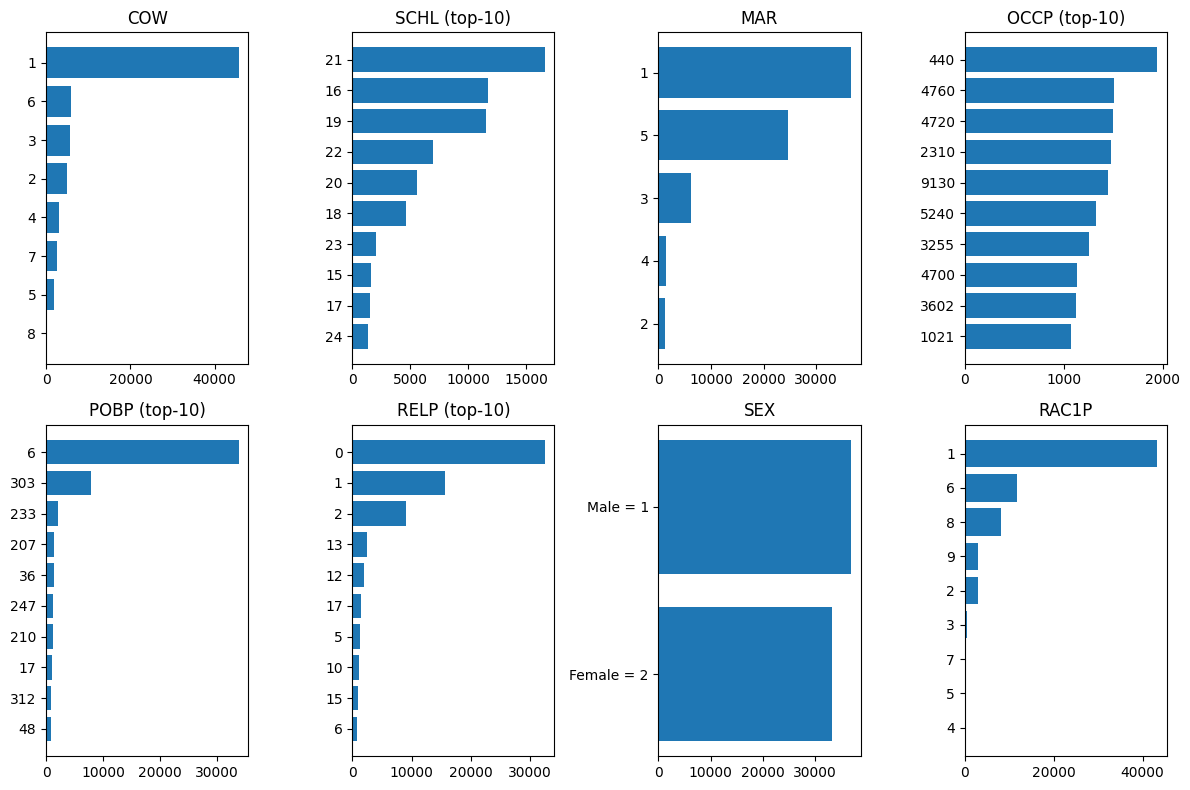

In [ ]:
# Plot distribution of categorical columns
fig, ax = plt.subplots(2,4,figsize=(12,8))
ax[0,0].barh(full_df['COW'].value_counts().index[::-1], full_df['COW'].value_counts()[::-1])
ax[0,0].set_title('COW')

ax[0,1].barh(full_df['SCHL'].value_counts().index[:10][::-1], full_df['SCHL'].value_counts()[:10][::-1])
ax[0,1].set_title('SCHL (top-10)')

ax[0,2].barh(full_df['MAR'].value_counts().index[::-1], full_df['MAR'].value_counts()[::-1])
ax[0,2].set_title('MAR')

ax[0,3].barh(full_df['OCCP'].value_counts().index[:10][::-1], full_df['OCCP'].value_counts()[:10][::-1])
ax[0,3].set_title('OCCP (top-10)')

ax[1,0].barh(full_df['POBP'].value_counts().index[:10][::-1], full_df['POBP'].value_counts()[:10][::-1])
ax[1,0].set_title('POBP (top-10)')

ax[1,1].barh(full_df['RELP'].value_counts().index[:10][::-1], full_df['RELP'].value_counts()[:10][::-1])
ax[1,1].set_title('RELP (top-10)')

ax[1,2].barh(full_df['SEX'].value_counts().index[::-1], full_df['SEX'].value_counts()[::-1])
ax[1,2].set_title('SEX')
labels = ('Female = 2', 'Male = 1')
ax[1,2].set_yticklabels(labels)

ax[1,3].barh(full_df['RAC1P'].value_counts().index[::-1], full_df['RAC1P'].value_counts()[::-1])
ax[1,3].set_title('RAC1P')

fig.tight_layout()

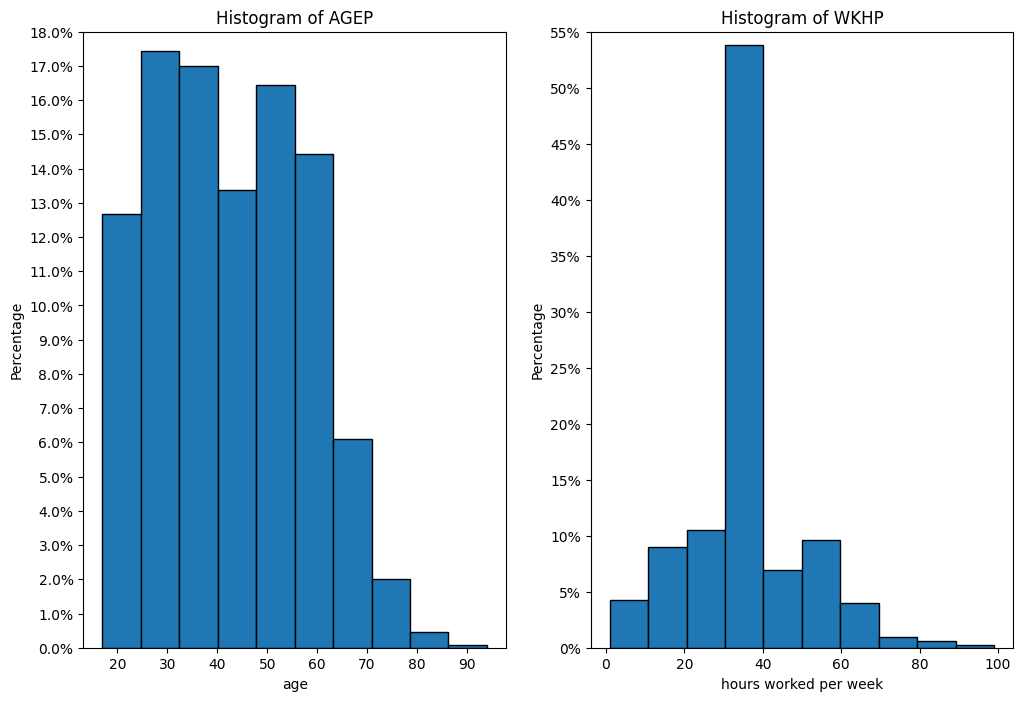

In [ ]:
# Plot distribution of numeric features
fig, ax = plt.subplots(1,2,figsize=(12,8))

#histogram for AGEP (age)
num_of_bins_agep = 10
y_vals_agep, x_vals_agep, e_agep = ax[0].hist(full_df['AGEP'], bins=num_of_bins_agep, edgecolor='black')
ax[0].set_title("Histogram of AGEP")
ax[0].set_xlabel("age")
ax[0].set_ylabel("Percentage")
y_max_agep = round((max(y_vals_agep) / len(full_df)) + 0.02, 2)
ax[0].set_yticks(ticks=np.arange(0.0, y_max_agep * len(full_df), 0.01 * len(full_df)))
ax[0].set_ylim(ax[0].get_yticks()[0], ax[0].get_yticks()[-1])
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(full_df)))

#histogram for WKHP (Hours worked per week)
num_of_bins_wkhp = 10
y_vals_wkhp, x_vals_wkhp, e_wkhp = ax[1].hist(full_df['WKHP'], bins=num_of_bins_wkhp, edgecolor='black')
ax[1].set_title("Histogram of WKHP")
ax[1].set_xlabel("hours worked per week")
ax[1].set_ylabel("Percentage")
y_max_wkhp = round((max(y_vals_wkhp) / len(full_df)) + 0.05, 2)
ax[1].set_yticks(ticks=np.arange(0.0, y_max_wkhp * len(full_df), 0.05 * len(full_df)))
ax[1].set_ylim(ax[1].get_yticks()[0], ax[1].get_yticks()[-1])
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(full_df)))

As we can see, there is nothing very unusual about the distritubtion of the features in this dataset. Also, we note that the proportion of men and women is rather balanced.

We can also examine the pairwise correlations between the numeric features and our target variable.

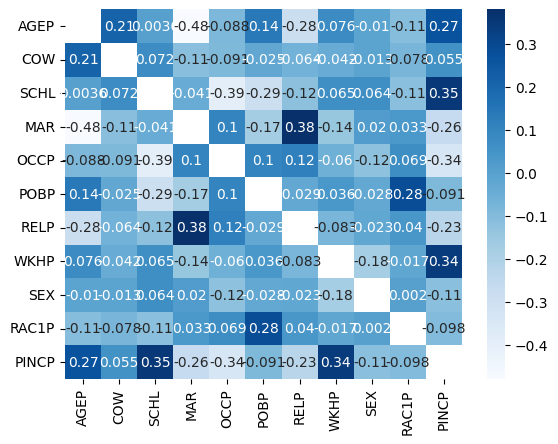

In [ ]:
# Plot pairwise correlations between numeric features

sns.heatmap(full_df.corr(), mask=np.identity(len(full_df.corr())), annot=True, cmap='Blues')
plt.show()

Here, we can see that there are only relatively low correlations between our target variable (PINCP) and our numeric features of age and hours worked per week.

Next, we can look at the distribution of our target variable as well as the joint distribution of our protected and target attributes.

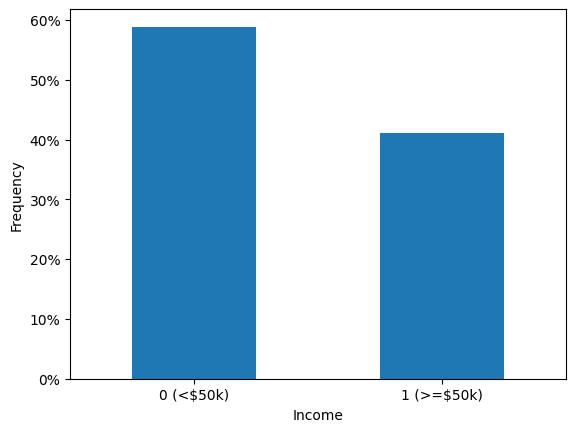

In [ ]:
# Examine distribution of target variable
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
full_df['PINCP'].value_counts().divide(full_df.shape[0]).plot(kind='bar')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
labels_target = ('0 (<$50k)', '1 (>=$50k)')
ax.set_xticklabels(labels_target)
plt.show()

From the graph above we note that there is a considerable imbalance of the target variable. Let's see how is this distribution looks by gender.

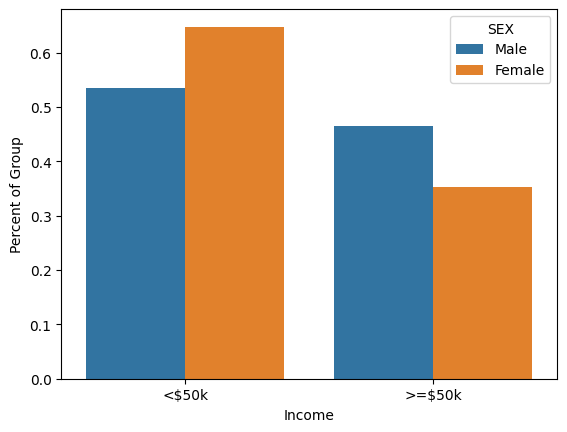

In [ ]:
#Plot distribution of target variable among males and plot distribution of target variable among females
hist_df = full_df.groupby(['SEX','PINCP']).size().to_frame('count').reset_index()
new_col = full_df.groupby(['SEX']).PINCP.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'SEX': {'1': 'Male', '2': 'Female'}}, inplace=True)
hist_df.replace({'PINCP': {0.0: '<$50k', 1.0: '>=$50k'}}, inplace=True)
sns.barplot(x='PINCP', y='frac', hue='SEX', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Income')
plt.show()

In [ ]:
# Showing the number of Males and Females per Income group
full_df.groupby(['SEX', 'PINCP'])['PINCP'].count()

SEX  PINCP
1    0.0      19727
     1.0      17122
2    0.0      21474
     1.0      11677
Name: PINCP, dtype: int64

Here, we can see that the proportion of males who make at least \$50k is higher than the proportion of females who make at least $50k in this dataset. Thus, the initial finding about imbalance of the target variable is more accentuated for females.

# **TODO 1**: Given the graphs above, what results might we expect from our classifier when it comes to labelling males and females as high or low income?

Your work here:

In [ ]:
# @title Answer
'''Since the proportion of males in this dataset that make at least $50k is higher than the proportion of females in this dataset
that make at least $50k, we might expect our classifier to have a bias for labelling males as higher income than females.'''

<!-- **Answer:** Since the proportion of males in this dataset that make at least \$50k is higher than the proportion of females in this dataset that make at least \$50k, we might expect our classifier to have a bias for labelling males as higher income than females. -->

# **TODO 2**: Why might this data be biased? What type of bias is this?

<!-- **Answer:** Males might be more inclined than females to inflate reports of their actual earnings.  Additionally, there are documented, historic discrepancies in compensation between males and females for similar work due to a variety reasons (discrepancies in education, labor market etc.). Therefore, the differences in income in this dataset could be reflections of a real-world wage-gap.  Both of these would be examples of "pre-existing bias" in this dataset. -->

Your work here:

In [ ]:
# @title Answer
'''Males might be more inclined than females to inflate reports of their actual earnings.  Additionally, there are documented,
historic discrepancies in compensation between males and females for similar work due to a variety reasons (discrepancies in
education,labor market etc.). Therefore, the differences in income in this dataset could be reflections of a real-world
wage-gap. Both of these would be examples of "pre-existing bias" in this dataset.'''

#**TODO 3**: Write some code that replicates the above histogram plot for black and white individuals in the data.

In [ ]:
#Your work here:

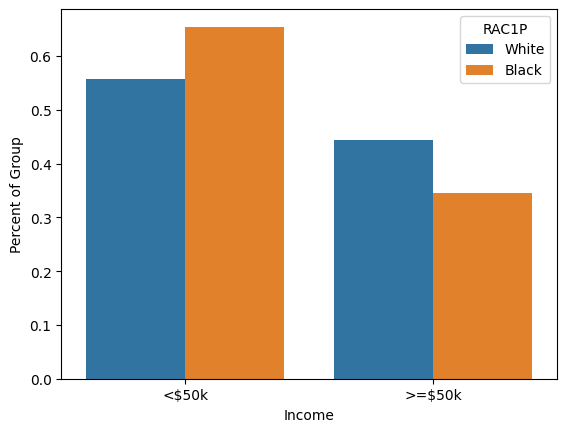

In [ ]:
# @title Answer
hist_df = full_df.groupby(['RAC1P','PINCP']).size().to_frame('count').reset_index()
new_col = full_df.groupby(['RAC1P']).PINCP.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df['RAC1P'] = hist_df['RAC1P'].map({'1': 'White', '2': 'Black'})#.fillna('Other')
hist_df.replace({'PINCP': {0.0: '<$50k', 1.0: '>=$50k'}}, inplace=True)
sns.barplot(x='PINCP', y='frac', hue='RAC1P', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Income')
plt.show()

## Preprocessing
Next, we will do some preprocessing on our data to prepare it for use in our model.

In [ ]:
# tandardize numerical features
scaler = StandardScaler()
full_df[numerical_cols] = scaler.fit_transform(full_df[numerical_cols])
display(full_df)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,-0.384944,1,8,1,3603,303,10,0.167025,1,8,0.0
1,-1.394788,1,11,1,6410,303,1,1.711336,1,1,0.0
2,-0.923527,1,9,1,6050,303,1,0.167025,2,1,0.0
3,0.894192,3,22,1,3710,6,1,0.553103,1,2,1.0
4,-1.327465,1,20,5,650,6,2,-0.219053,1,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.654235,1,22,5,1021,39,0,0.553103,1,1,1.0
69996,0.288285,6,9,4,4600,303,0,0.167025,2,1,0.0
69997,-0.990850,2,24,5,1760,6,0,0.167025,1,1,0.0
69998,1.432775,1,15,1,4850,301,1,0.167025,2,1,1.0


In [ ]:
# One-hot encode categorical features
full_df = pd.get_dummies(full_df, columns=categorical_cols)
display(full_df)

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX_1,SEX_2
0,-0.384944,0.167025,0.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,-1.394788,1.711336,0.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,-0.923527,0.167025,0.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0.894192,0.553103,1.0,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,-1.327465,-0.219053,0.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.654235,0.553103,1.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
69996,0.288285,0.167025,0.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
69997,-0.990850,0.167025,0.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
69998,1.432775,0.167025,1.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Since the sex attribute is already binary we can drop one of the redundant dummy columns
#note: males are now labeled as 1 and females are labeled as 0
full_df.drop(columns=['SEX_2'], inplace=True)
full_df.rename(columns={'SEX_1':'SEX'}, inplace=True)

full_df.head()

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX
0,-0.384944,0.167025,0.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,-1.394788,1.711336,0.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,-0.923527,0.167025,0.0,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,0.894192,0.553103,1.0,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,-1.327465,-0.219053,0.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


#2. Train Logistic Regression Classifier
Next, we will split our data into training and test sets randomly.  Then, we will train a logistic regression classifier and evaluate possible biases within that classifier.

### Aside: Accuracy as a Metric

Traditional machine learning (i.e. without a focus on fairness) often measures the quality of a classifier by it's **accuracy**, or what fraction of samples were labeled correctly:
$$
\text{Accuracy} = \frac{\text{Number of Correctly Labeled People}}{\text{Total Number of People}}
$$
This can also be expressed using the terms of the ["Confusion Matrix"](https://en.wikipedia.org/wiki/Confusion_matrix), where we let
- $\text{TP} = $ "True Positives" $ = \text{Num. people Correctly labeled as Positive}$
- $\text{FP} = $ "False Positives" $ = \text{Num. people Wrongly labeled as Positive}$
- $\text{TN} = $ "True Negatives" $ = \text{Num. people Correctly labeled as Negative}$
- $\text{FN} = $ "False Negatives" $ = \text{Num. people Wrongly labeled as Negative}$

Which lets us express the Accuacy as
$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
$$

In [ ]:
# Split data into training and test sets
target = full_df['PINCP']
full_df.drop(columns='PINCP', inplace=True)

#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(full_df, target, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (56000, 802)
X_test shape: (14000, 802)
y_train shape: (56000,)
y_test shape: (14000,)


#**TODO 4**: What would be the accuracy ($\frac{(TP + TN)}{(TP + FP + TN + FN)}$) of a classifier that always predicts the majority label (baseline classifier)?
Since the majority label is 0, the accuracy of this majority label classifier would be the number of 0's over the total number of records.


In [ ]:
# Your work here:

In [ ]:
# @title Answer
# Give the students the following:
# y_test.value_counts()
# # print(f'General baseline accuracy: {baseline_accuracy:.4f}')

target_zero = y_test.value_counts()[0]
target_one = y_test.value_counts()[1]
baseline_accuracy = target_zero / (target_zero+target_one)

print(f'General baseline accuracy: {baseline_accuracy:.4f}')

General baseline accuracy: 0.5942


#**TODO 5**: What would be the accuracy ($\frac{(TP + TN)}{(TP + FP + TN + FN)}$) for the Male and Female groups considering a classifier that always predicts the majority label (baseline classifier) for each of these groups?


In [ ]:
# Your work here:

In [ ]:
# @title Answer
# # print(f'Male baseline accuracy: {male_baseline_accuracy:.4f}')
# # print(f'Female baseline accuracy: {female_baseline_accuracy:.4f}')

male_zero = y_test[X_test['SEX']==1].value_counts()[0]
male_one = y_test[X_test['SEX']==1].value_counts()[1]
male_baseline_accuracy = male_zero / (male_zero + male_one)
print(f'Male baseline accuracy: {male_baseline_accuracy:.4f}')

female_zero = y_test[X_test['SEX']==0].value_counts()[0]
female_one = y_test[X_test['SEX']==0].value_counts()[1]
female_baseline_accuracy = female_zero / (female_zero + female_one)
print(f'Female baseline accuracy: {female_baseline_accuracy:.4f}')

Male baseline accuracy: 0.5495
Female baseline accuracy: 0.6441


In [ ]:
# Implement logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf_accuracy = clf.score(X_test, y_test)

clear_output()

print(f'Logistic Regression test accuracy: {clf_accuracy:.4f}')

## Evaluate fairness

Next, we will evaluate the fairness of our classifier on the test set. We first define the **selection rate** of the classifier on a group:
$$
\text{Selection Rate} = \frac{\text{Number of People Classified Positive}}{\text{Total Number of People}}
$$
We will compute the selection rate amongst men and amongst women, and compare them. The difference of their selection rates is called the **Demographic parity difference**, and the ratio of their rates is called the **Demographic parity ratio**.

In general, if we have more than 2 classes,
- The demographic parity difference is the difference of the largest and smallest selection rates, so it is always positive. A demographic parity difference of 0 means that all groups have the same selection rate.

- The demographic parity ratio is the ratio of the smallest to largest selection rates, so it is always between 0 and 1, where a ratio of 1 means that all groups have the same selection rate.

<!-- Next, we will evaluate the fairness of our classifier on the test set.  We will first focus on two metrics - demographic parity difference and demographic parity ratio.  **Demographic parity difference** is defined as the difference between the largest and the smallest group-level selection rate across all values of the sensitive feature(s).  A demographic parity difference of 0 means that all groups have the same selection rate.  **Demographic parity ratio** is defined as the ratio between the smallest and the largest group-level selection rate across all values of the sensitive feature(s).  A demographic parity ratio of 1 means that all groups have the same selection rate. -->

More formally: let $X$ denote a feature vector used for predictions, $A$ be a single sensitive feature (such as age or race), $Y$ be the true label, and $h$ a classifier or predictor resulted from a Machine Learning algorithm. Then:

*Demographic Parity Difference* is defined as $(max_a\mathbb{E}[h(X)~|~  A = a])~ - ~ (min_a\mathbb{E}[h(X)~|~  A = a]) $


*Demographic Parity Ratio* is defined as $\frac{max_a\mathbb{E}[h(X)~|~  A = a]}{min_a\mathbb{E}[h(X)~|~  A = a]} $

In [ ]:
# Evaluate the fairness of the classifier using `demographic_parity_difference` and `demographic_parity_ratio`
#note: we are conducting this analysis over the test set

#compute test predictions
y_pred = clf.predict(X_test)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Here, we can see that there are substantial differences in selection rates between males and females with males being significantly more likely to be classified as high income.

Fairlearn also provides the fairlearn.metrics.MetricFrame class to evaluate disparities in treatment between different sub-populations.

The **fairlearn.metrics.MetricFrame** object requires a minimum of four arguments:

*   The underlying metric function(s) to be evaluated
*   The true values
*   The predicted values
*   The sensitive feature values

Metric functions must have a signature ''fn(y_true, y_pred)'', i.e., require only two arguments.  Here we will again look at selection rate, but we will also examine a few other metrics.  We will use accuracy, selection rate, false negative rate, and false positive rate.

In [ ]:
# Evaluate the fairness of the classifier using the MetricFrame class for the `SEX` variable

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature_sex = X_test['SEX'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

The **fairlearn.metrics.MetricFrame** has the **overall** property, which evaluates the metrics on the entire dataset.

In [ ]:
grouped_on_sex.overall

# **TODO 6**: Evaluate fairness for the `RAC1P` variable (for black and white individuals at minimum), and show `grouped_on_race.overall`


In [ ]:
# Your work here:

In [ ]:
#@title Answer
sensitive_feature_race = (X_test['RAC1P_1'] + 2 * X_test['RAC1P_2'] ).replace({0:'other', 1:'white', 2:'black'})
indices = sensitive_feature_race != 'other'
#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_race = MetricFrame(metrics=metrics,
                             y_true=y_test[indices],
                             y_pred=y_pred[indices],
                             sensitive_features=sensitive_feature_race[indices])

In [ ]:
print(y_pred[indices].shape)

In [ ]:
grouped_on_race.overall

The **fairlearn.metrics.MetricFrame** object also has the **by_group** functionality. This displays the selected metrics evaluated on each subgroup defined by the categories in the sensitive_features (sex in our case).

In [ ]:
grouped_on_sex.by_group

# **TODO 7**: Display for `RAC1P` as well

In [ ]:
# Your work here:

In [ ]:
#@title Answer
grouped_on_race.by_group

Reminder: Females are labeled 0 and males are labeled 1.

In [ ]:
# Plot the metric values

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
    )

grouped_on_sex_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by sex",
    )

#**TODO 8**: Replicate the above plots for at `RAC1P` and at least black/white individuals in the data.

In [ ]:
# Your answer here:

In [ ]:
# @title Answer
grouped_on_race_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_race)

grouped_on_race_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_race)

grouped_on_race_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by race",
    )

grouped_on_race_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by race",
    )

# **TODO 9**: Observe that accuracy for male and female groups is comparable, and yet we see disparities in FPR and FNR.  Which group benefits from the discrepancies in FPR and FNR shown above?  If you were deploying this system how would you measure performance (eg. accuracy, FNR, FPR)? (Reminder: females are labelled 0, males are labelled 1)


Your work here:

In [ ]:
#@title Answer
'''
<Males benefit from both a lower false negative rate and a higher false positive rate.  They are less likely to be incorrectly classified
as "low income" and are also more likely to be incorrectly classified as "high income".  When designing a classifier we would want to look
beyond accuracy and selection rate and consider FPR and FNR.'''

#3. Train "Blind" Logistic Regression Classifier (Fairness through Blindness)

Next, we will remove the protected attribute of "sex" from our data and see what effect this has on the performance of our classifier.

In [ ]:
#Remove sensitive attribute from data
X_train_blind = X_train.drop(columns='SEX')
X_test_blind = X_test.drop(columns='SEX')

In [ ]:
# Implement logistic regression
clf_blind = LogisticRegression()
clf_blind.fit(X_train_blind, y_train)
clf_blind_accuracy = clf_blind.score(X_test_blind, y_test)

clear_output()

print(f'Logistic Regression test accuracy (without sensitive attribute): {clf_blind_accuracy:.4f}')

In [ ]:
# Recall the accuracy fairness of the original classifier
print('Recall the original classifier:')
print(f'Logistic Regression test accuracy: {clf_accuracy:.4f}')
print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')
print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

In [ ]:
# Evaluate fairness of the blind classifier

#compute test predictions
y_pred_blind = clf_blind.predict(X_test_blind)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_blind, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference (without sensitive attribute): {demo_parity_diff_blind:.4f}')
print(f'Demographic parity ratio (without sensitive attribute): {demo_parity_ratio_blind:.4f}')

#compute selection rate for males and females
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

print(f'Male selection rate (without sensitive attribute): {male_selection_rate_blind:.4f}')
print(f'Female selection rate (without sensitive attribute): {female_selection_rate_blind:.4f}')



# **TODO 10:** describe the differences of both models in terms of accuracy and fairness among male and female groups?


Your work here:

In [ ]:
#@title Answer
'''Here, we can see that removing the protected attribute from our data had very little impact on the model's accuracy. On the other hand,
the fairness metrics improved considerably as the Demographic Parity Difference decreased and the Demographic Parity Ratio increased.'''

**Nevertheless**, we see that removing the protected feature did not eliminate the biases within our classifier, as exhibited below.

In [ ]:
#Evaluate the biases of the classifier using the MetricFrame class
grouped_on_sex_blind = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_blind,
                                     sensitive_features=sensitive_feature_sex)

In [ ]:
grouped_on_sex_blind.overall

In [ ]:
grouped_on_sex_blind.by_group

## Showing all the metrics for the full data and blinded data.

In [ ]:
#Comparing the results: full-data vs. blinded data

#demographic parity difference
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

#demographic parity ratio
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

#selection rate
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#fnr
male_fnr = false_negative_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_fnr_blind = false_negative_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_fnr = false_negative_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_fnr_blind = false_negative_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#fpr
male_fpr = false_positive_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_fpr_blind = false_positive_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_fpr = false_positive_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_fpr_blind = false_positive_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#plot
labels = ['Demo Parity Diff','Demo Parity Ratio','Sel Rate (Male)',
          'Sel Rate (Female)', 'FNR (Male)', 'FNR (Female)', 'FPR(Male)',
          'FPR(Female)']

Y_full = [demo_parity_diff, demo_parity_ratio, male_selection_rate,
          female_selection_rate, male_fnr, female_fnr, male_fpr, female_fpr]

Y_blind = [demo_parity_diff_blind, demo_parity_ratio_blind,
           male_selection_rate_blind, female_selection_rate_blind, male_fnr_blind,
           female_fnr_blind, male_fpr_blind, female_fpr_blind]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(x - width/2, Y_full, width, label='Full Model')
rects2 = ax.bar(x + width/2, Y_blind, width, label='Blind Model')

ax.set_title('Metrics Comparison', size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize='x-large')
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.set_ylim([0, 1])
fig.tight_layout()
plt.rcParams["figure.figsize"] = (18,8)
plt.show()


## Conclusion
**Summary:**

Bias in AI Systems: The lab began by examining the COMPAS tool’s racial and gender biases in recidivism predictions, illustrating the need for fairness in AI.

Reproducing Analysis: Participants replicated ProPublica’s findings using the COMPAS dataset, focusing on logistic regression to detect bias patterns.

Fairness with Fairlearn: The lab introduced Fairlearn for evaluating and mitigating biases in machine learning models, using the ACS dataset to address fairness in predictions related to sex.

Mitigating Bias: Practical steps for improving model fairness were discussed, including fairness-aware modeling and adjustments to balance performance and equity.

Responsible AI: The lab underscores the importance of addressing bias in AI systems and provides tools and insights for implementing responsible AI practices






## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />